# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
import numpy as np
from abc import ABC, abstractmethod
from sklearn.tree import DecisionTreeClassifier   # for Task 4
from sklearn.base import clone                    # optional for Task 4
import matplotlib.pyplot as plt                   # for Task 5
from sklearn.metrics.pairwise import rbf_kernel   # for Task 6

In [2]:
class MAB(ABC):
    """Base class for a contextual multi-armed bandit (MAB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.
    """
    def __init__(self, n_arms):
        if not np.issubdtype(type(n_arms), np.integer):
            raise TypeError("`n_arms` must be an integer")
        if not n_arms >= 0:
            raise ValueError("`n_arms` must be non-negative")
        self.n_arms = n_arms
        # your code here (if you like)
        
    @abstractmethod
    def play(self, context):
        """Play a round
        
        Parameters
        ----------        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors presented to the MAB. The 0-th 
            axis indexes the arms, and the 1-st axis indexes the features.
            Non-contextual bandits accept a context of None.
        
        Returns
        -------
        arm : int
            Integer index of the arm played this round. Should be in the set 
            {0, ..., n_arms - 1}.
        """
        # your code here (if you like)
    
    @abstractmethod
    def update(self, arm, reward, context):
        """Update the internal state of the MAB after a play
        
        Parameters
        ----------
        arm : int
            Integer index of the played arm in the set {0, ..., n_arms - 1}.
        
        reward : float
            Reward received from the arm.
        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors that was presented to the MAB. The 
            0-th axis indexes the arms, and the 1-st axis indexes the 
            features. Non-contextual bandits accept a context of None. 
        """
        # your code here (if you like)

In [3]:
# Define global functions here, if required


## 1. Implement ε-greedy and UCB MABs

In [4]:
class EpsGreedy(MAB):
    """Epsilon-Greedy multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms

    epsilon : float
        Explore probability. Must be in the interval [0, 1].

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, epsilon, Q0=np.inf):
        if not (type(epsilon) == float or type(epsilon) == np.float64):
            raise TypeError("`epsilon` must be a float")
        if not epsilon >= 0:
            raise ValueError("`epsilon` must be non-negative")
            
        super().__init__(n_arms)
        # your code here
        
        self.epsilon = epsilon
        
        # initialize values
        self.count_per_arm = [0 for arm in range(n_arms)]
        
        # Initialize all the arms with zero total reward
        self.q_values = [Q0 for arm in range(n_arms)]
        
        # Initialize all the arms with zero total reward
        self.total_reward_per_arm = [0 for arm in range(n_arms)] 


    
    def play(self, context=None):
        super().play(context)
        # your code here
        
        # perform exploration
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.q_values, 1)
        # perform exploitation
        else:
            # Get highest q-value from current q-values
            highest = max(self.q_values)
            highest_Qs = [index for index, value in enumerate(self.q_values) if value == highest]
            
            if len(highest_Qs) > 1:
                action = np.random.choice(highest_Qs) #random tie breaking
            else:
                action = highest_Qs[0]
        return action
        
        
    def update(self, arm, reward, context=None):
        if not (type(reward) ==  float or type(reward) == np.float64):
            raise TypeError("Reward` must be a float")
        if not arm > 0 and not arm <=self.n_arms:
            raise ValueError("Arm must be positive integer and may not be larger than self._narms")
        super().update(arm, reward, context)
        # your code here
                
        # update the step of individual arms
        self.count_per_arm[arm] += 1
        
        # update total reward
        self.total_reward_per_arm[arm] += reward
        
        # update q-values each arm
        updated_reward =  self.total_reward_per_arm[arm] / self.count_per_arm[arm]
        self.q_values[arm] = updated_reward
        
        return

In [5]:
class UCB(MAB):
    """Upper Confidence Bound (UCB) multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms.

    rho : float
        Positive real explore-exploit parameter.

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, rho, Q0=np.inf):
        if not (type(rho) == float or type(rho) == np.float64):
            raise TypeError("`rho` must be a float")
        if not rho > 0:
            raise ValueError("`rho` must be strictly positive")
        if not np.isreal(rho):
            raise ValueError("`rho` must be a real number")
        
        super().__init__(n_arms)
        # your code here

        # set rho
        self.rho = rho
        
        # Step count for each arm
        self.count_per_arm = [0 for arm in range(n_arms)]
        self.total_rounds = 0
        
        # Mean reward for each arm
        self.q_values = [Q0 for arm in range(n_arms)]
        
        # Initialize all arms with zero reward
        self.total_reward_per_arm = [0 for arm in range(n_arms)] 
    
    def play(self, context=None):
        super().play(context)
        # your code here
        
        #copy each arm with reward for later calculation at tround
        previous_values = self.q_values
        
        for arm in range(self.n_arms):
            if self.count_per_arm[arm] == 0: # Use intial values for the first round
                continue
                
            else:
                # Calculate q-value with exlpore boost for each arm
                exploration_hyperparameter = self.rho * np.log(self.total_rounds) / self.count_per_arm[arm]
                
                previous_values[arm] = previous_values[arm] + np.sqrt(exploration_hyperparameter)
            
        # Get the highest value from current values
        highest = max(previous_values)
        # find all elements with highest values 
        highest_Qs = [index for index, value in enumerate(previous_values) if value == highest]
        
        if len(highest_Qs) > 1:
            action = np.random.choice(highest_Qs) # perform random tie breaking
        else:
            action = highest_Qs[0]
        
        return action
        
    def update(self, arm, reward, context=None):
        if not (type(reward) ==  float or type(reward) == np.float64):
            raise TypeError("Reward` must be a float")
        if not arm > 0 and not arm <=self.n_arms:
            raise ValueError("Arm must be positive integer and may not be larger than self._narms")
            
        super().update(arm, reward, context)
        # your code here

        # update the step of individual arms
        self.count_per_arm[arm] += 1
        
        self.total_rounds += 1
        
        # update total reward
        self.total_reward_per_arm[arm] += reward
        
        # update q-values each arm
        updated_reward =  self.total_reward_per_arm[arm] / self.count_per_arm[arm]
        self.q_values[arm] = updated_reward
        return

## 2. Implement off-policy evaluation

In [6]:
def offlineEvaluate(mab, arms, rewards, contexts, n_rounds=None):
    """Offline evaluation of a multi-armed bandit
    
    Parameters
    ----------
    mab : instance of MAB
        MAB to evaluate.
    
    arms : integer numpy.ndarray, shape (n_events,) 
        Array containing the history of pulled arms, represented as integer 
        indices in the set {0, ..., mab.n_arms}
    
    rewards : float numpy.ndarray, shape (n_events,)
        Array containing the history of rewards.
    
    contexts : float numpy.ndarray, shape (n_events, n_arms, n_dims)
        Array containing the history of contexts presented to the arms. 
        The 0-th axis indexes the events in the history, the 1-st axis 
        indexes the arms and the 2-nd axis indexed the features.
        
    n_rounds : int, default=None
        Number of matching events to evaluate the MAB on. If None, 
        continue evaluating until the historical events are exhausted.
    
    Returns
    -------
    out : float numpy.ndarray
        Rewards for the matching events.
    """
    if not rewards.shape==(num_of_events,):
        raise TypeError("`Reward` must be a 1-dimensional array")
    if not n_rounds > 0 or n_rounds is None:
        raise ValueError("n_rounds must be positive integer or None")
    h0 = [] # history list
    R0 = [] # total payoff list
        
    count = 0
    for event in range(num_of_events):
        #If reached maximum number of rounds then stop (or repeat until last event)
        if len(h0) == n_rounds:     
            break
            
        #Play an arm
        action = mab.play(contexts[event])
        #print(action)
        
        #If the chosen arm is equal to the arm in the log
        # we record the history, the payoff and update the arm
        if action == arms[event]:
            # increase count of valid events
            count +=1
            
            h0.append(event)
            R0.append(rewards[event])
            mab.update(arms[event],rewards[event],contexts[event])
    
    return R0

In [7]:
# load dataset here

#Initial three lists which respects
# to arm, reward, and context(feature_list in this case).
arm_list = []
reward_list = []
features_list = []
num_of_events = 0

#Read each line and split by spaces. Record arm, reward and context into the lists
with open("dataset.txt","r") as f:
    dataset = f.readlines()
    
for line in dataset:
    num_of_events += 1
    current_line = line.split()
    
    # get arm from dataset
    arm = int(current_line[0])
    
    # get reward from dataset
    reward = float(current_line[1])
    
    # get features from dataset
    features = current_line[2:]
    features = [float(element) for element in features]
    
    arm_list.append(arm)
    reward_list.append(reward)
    features_list.append(features)
    
#Convert lists into np_array
arms = np.array(arm_list)
rewards = np.array(reward_list)

#For each event, the context is 10*10 dim 
# because there are 10 arms, and each one of them has 10 features 
contexts = np.array(features_list).reshape(num_of_events,(10*10))

In [8]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.26625


In [9]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.10125


## 3. Implement LinUCB contextual MAB

In [10]:
class LinUCB(MAB):
    """Contextual multi-armed bandit (LinUCB)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    alpha : float
        Positive real explore-exploit parameter.
    """
    def __init__(self, n_arms, n_dims, alpha):
        super().__init__(n_arms)
        # your code here
        
        if not (type(alpha) == float or type(alpha) == np.float64):
            raise TypeError("`alpha` must be a float")
        if not alpha > 0.0 :
            raise ValueError("`alpha` must be strictly positive")
        if not np.isreal(alpha):
            raise ValueError("`alpha` must be a real number")
        if not n_dims > 0:
            raise ValueError("`n_dims` must be strictly positive")    
        
        self.n_dims = n_dims
        self.alpha = alpha
        
        #A is list of each arm with D.T * D + I 
        self.A_a = [np.identity(n_dims) for arm in range(n_arms)]
        #b is reward list
        self.b_a = [np.zeros(n_dims) for arm in range(n_arms)]


    def play(self, context):
        super().play(context)
        # your code here 
        if not context.shape == (self.n_arms*self.n_dims,):
            raise TypeError("`context` must be a numeric array of length self.n_dims * self.n_arms")

        arm_with_Q = [float('inf') for arm in range(self.n_arms)] #At particular round, initial arm with empty posterior distribution
        
        context = context.reshape(self.n_arms, self.n_dims)
        
        for arm in range(0,self.n_arms):
            #For each arm, calculate posterior distribution based on theta and std
            Theta_a = np.dot(np.linalg.inv(self.A_a[arm]), self.b_a[arm])
            std = np.sqrt(np.linalg.multi_dot([np.transpose(context[arm]), np.linalg.inv(self.A_a[arm]), context[arm]]))
            p_ta = np.dot(Theta_a.T,context[arm]) + self.alpha * std
            
            if not np.isnan(p_ta):#make sure the result of calculation is valid number
                arm_with_Q[arm] = p_ta
            
        #Getting the highest value from posterior distribution, then find the corresponding key and append them
        highest = max(arm_with_Q)
        
        highest_Qs = [index for index, value in enumerate(arm_with_Q) if value == highest]

        if len(highest_Qs)>1:
            action = np.random.choice(highest_Qs) # tie breaker
        else:
            action = highest_Qs[0]
        
        return action
        
    
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        # your code here
        
        if not arm >= 0 and arm <=self.n_arms:
            raise TypeError("`arm` must be a positive integer and no larger than self.n_arms")
        if not (type(reward) ==  float or type(reward) == np.float64):
            raise TypeError("Reward` must be a float")
        if not context.shape == (self.n_arms*self.n_dims,):
            raise TypeError("`context` must be a numeric array of length self.n_dims * self.n_arms")

        context = context.reshape(self.n_arms,self.n_dims)
            
        if arm <= self.n_arms:
            #Reshap the vector to matrix, or the calculation will be incorrect because the transpose will not take effects
            context_Matrix = context[arm].reshape(-1,1)
            context_times_contextT = np.dot(context_Matrix,context_Matrix.T)
            
            self.A_a[arm] = np.add(self.A_a[arm], context_times_contextT)
            
            self.b_a[arm] = np.add(self.b_a[arm], np.dot(reward,context[arm]))

In [11]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 4. Implement TreeBootstrap contextual MAB

In [109]:
class TreeBootstrap(MAB):
    """Contextual Thompson sampled multi-armed bandit (TreeBootstrap)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    tree : instance of sklearn.tree.DecisionTreeClassifier, optional
        Decision tree to use for predicting the expected future reward. 
        Defaults to sklearn.tree.DecisionTreeClassifier().
    """
    def __init__(self, n_arms, n_dims, tree=DecisionTreeClassifier()):
        super().__init__(n_arms)
        # your code here
        # TODO: perform input validaton
        
        self.n_dims = n_dims
        self.tree = tree
        self.total_rounds = 0
        # self.historical_data = [np.zeros(n_dims) for arm in range(n_arms)]
        self.historical_data = [[] for arm in range(n_arms)]
        self.my_decision_trees = {}
        
    def play(self, context):
        super().play(context)
        # your code here
        
        # TODO: perform input validaton

        # get the flattened context and reshape it to an array of shape (narms,ndims)        
        # observe context vectors
        context = np.reshape(context, (self.n_arms, self.n_dims))
        #print(context)

        self.my_decision_trees[self.total_rounds] = [clone(self.tree) for arm in range(self.n_arms)]              
        
        my_predictions = [0 for arm in range(self.n_arms)]

        for i in range(self.n_arms):
                    
            if len(self.historical_data[i]) == 0:
                # set decision tree to predict 1 for any input      
                X = context[i].reshape(1, -1)
                y = [1]                
                self.my_decision_trees[self.total_rounds][i].fit(X = X, y= y)
            else: 
                # Sample bootstrapped dataset Dt,a from Dt,a
                # fit  decision tree
                
                #sampling |Dt,a| ob- servations from Dt,a with replacement
                #print(len(self.historical_data[i]))
                
                #my_random_numbers = np.random.randint(len(self.historical_data[i]), size=len(self.historical_data[i]))
                
                #print(my_random_numbers)
                #sampled_data = self.historical_data[my_random_numbers]
                X = []
                y = []
                
                for element in self.historical_data[i]:
                    #print(element[0].reshape(1, -1))
                    #print(element[0].reshape(1, -1))
                    X.append(element[0].reshape(1,-1).flatten())
                    y.append(element[1])
                
                #print(X)
                #print(y)
                self.my_decision_trees[self.total_rounds][i].fit(X, y)
        
        # Choose action at = arg maxa pˆ(θt,a, xt,a)
        for i in range(self.n_arms):
            x_t = context[i].reshape(1,-1)
            #print(x_t)
            #print(self.my_decision_trees[self.total_rounds][i].predict(x_t)[0])
            my_predictions[i] = self.my_decision_trees[self.total_rounds][i].predict(x_t)[0]
        
        #print(my_predictions)
        highest = max(my_predictions)  
        highest_Qs = [index for index, value in enumerate(my_predictions) if value == highest]

        if len(highest_Qs)>1:
            action = np.random.choice(highest_Qs) # tie breaker
        else:
            action = highest_Qs[0]

        return action
    
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        # your code here
        
        # TODO: perform input validaton
        
        context = context.reshape(self.n_arms,self.n_dims)
        
        # pass the arm-specific context (xt,a,)
        x_t = context[arm].reshape(-1,1)
        
        context_reward_pair = []
        
        # if|Dt,at|=0
        if len(self.historical_data[arm]) == 0:
            # Update Dt,at with (xt,at , 0) and (xt,at , 1)
            self.historical_data[arm].append((x_t, 0))
            self.historical_data[arm].append((x_t, 1))
    
        # Update Dt,at with (xt,at , rt,at )
        
        # TODO: perform Update step (i.e. set correct reward for x_t elements)
        self.historical_data[arm].append((x_t, reward))
        
        #print(self.historical_data[self.total_rounds][arm])

        self.total_rounds += 1

In [110]:
mab = TreeBootstrap(10, 10)
results_TreeBootstrap = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('TreeBootstrap average reward', np.mean(results_TreeBootstrap))

TreeBootstrap average reward 0.76625


In [ ]:
# TODO: Add code for TreeBootstrap

# TODO: Remove code from below
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
mab = TreeBootstrap(10, 10)
results_TreeBootstrap = offlineEvaluate(mab, arms, rewards, contexts, 800)


# your code here
EpsGreedy_reward = []
UCB_reward = []
linUCB_reward = []
TreeBootstrap_reward = []

total_round = []
count = 0

for round in range(0,800):
    count +=1
    if round == 0: #calculate initial reward 
        EpsGreedy_reward.append(results_EpsGreedy[round]/count)
        UCB_reward.append(results_UCB[round]/count)
        linUCB_reward.append(results_LinUCB[round]/count)
        TreeBootstrap_reward.append(results_TreeBootstrap[round]/[count])
    else:  # calculate cumulated reward
        results_EpsGreedy[round] += results_EpsGreedy[round-1] 
        EpsGreedy_reward.append(results_EpsGreedy[round]/count)
        
        results_UCB[round]+= results_UCB[round-1]
        UCB_reward.append(results_UCB[round]/count)
        
        results_LinUCB[round]+= results_LinUCB[round-1]
        linUCB_reward.append(results_LinUCB[round]/count)
        
        results_TreeBootstrap[round] += results_TreeBootstrap[round-1]
        TreeBootstrap_reward.append(results_TreeBootstrap[round]/[count])
        
        
plt.plot(np.linspace(1,800,800),EpsGreedy_reward, label = r"$\epsilon$-Greedy")
plt.plot(np.linspace(1,800,800),UCB_reward, label = "UCB")
plt.plot(np.linspace(1,800,800),linUCB_reward, label = "LinUCB")
plt.plot(np.linspace(1,800,800),TreeBootstrap_reward, label = "TreeBootstrap")
plt.ylabel('Per-round Cumulative Reward')
plt.xlabel('Rounds')
plt.legend()
plt.show()

### 5.B.

Optimal alpha value to maximize reward:  0.02


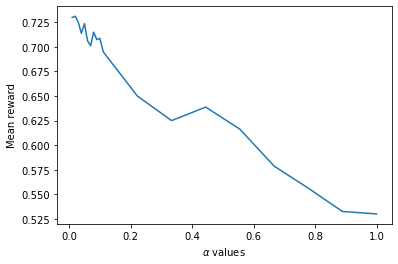

In [15]:
# your code here

#First Interval [0.1, 0.2, 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.] - zero removed
alpha_params_large_interval = np.linspace(0,1,10)[1:]

#Second Interval [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1] - zero removed
alpha_params_small_interval = np.linspace(0,0.1,11)[1:]

#Append two intervals and sort
alpha_grid_search_params = np.append(alpha_params_large_interval,alpha_params_small_interval) 
alpha_grid_search_params = np.sort(alpha_grid_search_params)

results_LinUCB_with_alpha_search = []
for alpha in alpha_grid_search_params:
    mab = LinUCB(10, 10, alpha)
    results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
    results_LinUCB_with_alpha_search.append(np.mean(results_LinUCB))
   
print('Optimal alpha value to maximize reward: ', alpha_grid_search_params[np.argmax(results_LinUCB_with_alpha_search)])
plt.plot(alpha_grid_search_params, results_LinUCB_with_alpha_search)
plt.ylabel('Mean reward')
plt.xlabel(r'$\alpha$ values')
plt.show()

## 6. Implement KernelUCB contextual MAB

In [21]:
class KernelUCB(MAB):
    """Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    gamma : float
        Positive real explore-exploit parameter.
    
    eta : float
        Positive real explore-exploit parameter.
    
    kern : callable
        A kernel function from sklearn.metrics.pairwise.
    """
    def __init__(self, n_arms, n_dims, gamma, eta, kern):
        super().__init__(n_arms)
        # your code here
        
        # TODO: perform input validation
        # TODO: Perform refactoring
        
        # Number of context features
        self.n_dims = n_dims
        # regularization parameter
        self.eta = eta
        # explore-exploit parameter
        self.gamma = gamma
        # kernel function
        self.kern = kern
        
        self.total_rounds = 0
 
        # u_n_t values
        self.u = np.zeros(self.n_arms)
        # sigma_n_t values
        self.sigma = np.zeros(self.n_arms)
        # list of contexts of chosen actions to the moment
        self.pulled = []
        # list of rewards corresponding to chosen actions to the moment
        self.rewards = []
        # define a dictionary to store kernel matrix inverse in each tround
        self.Kinv = {}
        
        
    def play(self, context):
        super().play(context)
        # your code here
        
        # TODO: perform input validation

        # get the flattened context and reshape it to an array of shape (narms,ndims)
        context = np.reshape(context, (self.n_arms, self.n_dims))
        
        # in inittial round
        if self.total_rounds == 0:
            # playing action 1 for first round and setting u_0[0] to 1.0
            self.u[0] = 1.0
        else:
            
            #========================================
            #    Calculating all possible k_x ...
            #========================================
        
            # To perform kernel UCB in the least and efficient time as possible I propose to
            # calculate k_x for all of the contexts and not just for chosen context (x_t)
            # this will be hugely beneficiary to calculating sigma_n_t step in for loop
        
            # calculate the kernel between each of the contexts of narms and the pulled 
            # contexts of chosen arms to the moment
        
            # self.pulled is just a list of arrays, and hence reshaping it to a valid
            # numpy array of shape (tround+1,ndims). Since tround is starting from zero
            # it is being added by 1 to give valid shape in each round especially for
            # the first round
            k_x = self.kern(context, np.reshape(self.pulled,(self.total_rounds,self.n_dims)))
            
            #===============================
            #    MAIN LOOP ...
            #===============================
            
            for i in range(self.n_arms):
                temp = self.kern(context[i].reshape(1,-1), context[i].reshape(1,-1)) - k_x[i].T.dot(self.Kinv[self.total_rounds-1]).dot(k_x[i])
                self.sigma[i] = np.sqrt(temp)  
                self.u[i] = k_x[i].T.dot(self.Kinv[self.total_rounds-1]).dot(self.y) + (self.eta / np.sqrt(self.gamma)) * self.sigma[i]
            
        highest = max(self.u)  
        highest_Qs = [index for index, value in enumerate(self.u) if value == highest]

        if len(highest_Qs)>1:
            action = np.random.choice(highest_Qs) # tie breaker
        else:
            action = highest_Qs[0]
        
        return action
    
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        # your code here
        
        # TODO: perform input validation
        
        # get the flattened context and reshape it to an array of shape (narms,ndims)
        context = np.reshape(context, (self.n_arms,self.n_dims))
        # append the context of choesn arm (index = [arm]) with the previous list of contexts (self.pulled)
        # the obserbved context is being reshaped into a column vector simultanesously for future kernel calculations
        
        self.pulled.append(context[arm].reshape(1,-1))
        # set currently observed context of chosen arm as x_t
        # data has single feature, hence reshaping
        x_t = context[arm].reshape(1, -1)
        #print(context[arm])
        #print(context[arm].reshape(1,-1))


        #========================================
        #    Calculating all possible k_x ...
        #========================================
        
        # To perform kernel UCB in the least and efficient time as possible I propose to
        # calculate k_x for all of the contexts and not just for chosen context (x_t)
        # this will be hugely beneficiary to calculating sigma_n_t step in for loop
        
        # calculate the kernel between each of the contexts of narms and the pulled 
        # contexts of chosen arms to the moment
        
        # self.pulled is just a list of arrays, and hence reshaping it to a valid
        # numpy array of shape (tround+1,ndims). Since tround is starting from zero
        # it is being added by 1 to give valid shape in each round especially for
        # the first round
        k_x = self.kern(context,np.reshape(self.pulled,(self.total_rounds+1,self.n_dims)))
        
        # append the observed reward value of chosen action to the previous list of rewards
        self.rewards.append(reward)
        
        # generate array of y. Since tround is starting from zero
        # it is being added by 1 to give valid shape in each round especially for
        # the first round
        self.y = np.reshape(self.rewards,(self.total_rounds+1, 1))
        
        # building inverse of kernel matrix for first round is different from consequent rounds.
        if self.total_rounds==0:
            self.Kinv[self.total_rounds] = 1.0/(self.kern(x_t,x_t) + self.gamma)
            
            #print(self.kern(x_t, x_t))
            #print(self.Kinv[self.total_rounds])
        else:
            # set inverse of kernel matrix as the kernel matrix inverse of the previous round
            Kinv = self.Kinv[self.total_rounds-1]
            # set b as k_(x_t) excluding the kernel value of the current round
            b = k_x[arm][:-1]
            # reshape b into the valid numpy column vector
            b = b.reshape(self.total_rounds, 1)
            
            # compute b.T.dot( kernel matrix inverse)
            bKinv = np.dot(b.T,Kinv)
            # compute (kernel matrix inverse).dot(b)
            Kinvb = np.dot(Kinv,b)
            
            #==========================================================================
            #    Calculating components of current Kernel matrix inverse (Kinv_tround)
            #==========================================================================
            
            K22 = 1.0 / (k_x[arm][-1] + self.gamma - np.dot(bKinv,b))            
            K11 = Kinv + K22 * np.dot(Kinvb, bKinv)
            K12 = -K22 * Kinvb
            K21 = -K22 * bKinv
            
            K11 = np.reshape(K11,(self.total_rounds, self.total_rounds))
            K12 = np.reshape(K12,(self.total_rounds, 1))
            K21 = np.reshape(K21,(1, self.total_rounds))
            K22 = np.reshape(K22,(1,1))
            
            # stack components into an array of shape(self.total_rounds, self.total_rounds)
            self.Kinv[self.total_rounds] = np.vstack((np.hstack((K11,K12)),np.hstack((K21,K22)))) 
                
        self.total_rounds += 1             
        

In [22]:
mab = KernelUCB(10, 10, 1.0, 0.1, rbf_kernel)
results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('KernelUCB average reward', np.mean(results_KernelUCB))

KernelUCB average reward 0.70125


[[1.]]


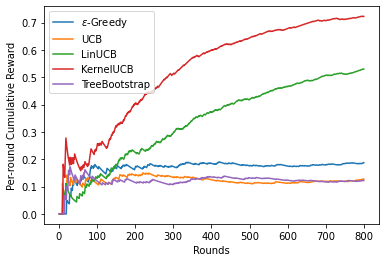

In [20]:
# your plotting code here

# TODO: Add code for TreeBootstrap

# TODO: Remove code from below
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
mab = KernelUCB(10, 10, 1.0, 0.1, rbf_kernel)
results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
mab = TreeBootstrap(10, 10)
results_TreeBootstrap = offlineEvaluate(mab, arms, rewards, contexts, 800)


# your code here
EpsGreedy_reward = []
UCB_reward = []
linUCB_reward = []
kernelUCB_reward = []
TreeBootstrap_reward = []


total_round = []
count = 0

for round in range(0,800):
    count +=1
    if round == 0: #calculate initial reward 
        EpsGreedy_reward.append(results_EpsGreedy[round]/count)
        UCB_reward.append(results_UCB[round]/count)
        linUCB_reward.append(results_LinUCB[round]/count)
        kernelUCB_reward.append(results_KernelUCB[round]/count)
        TreeBootstrap_reward.append(results_TreeBootstrap[round]/count)
        
    else:  # calculate cumulated reward
        results_EpsGreedy[round] += results_EpsGreedy[round-1] 
        EpsGreedy_reward.append(results_EpsGreedy[round]/count)
        
        results_UCB[round]+= results_UCB[round-1]
        UCB_reward.append(results_UCB[round]/count)
        
        results_LinUCB[round]+= results_LinUCB[round-1]
        linUCB_reward.append(results_LinUCB[round]/count)
        
        results_KernelUCB[round]+= results_KernelUCB[round-1]
        kernelUCB_reward.append(results_KernelUCB[round]/count)
        
        results_TreeBootstrap[round] += results_TreeBootstrap[round-1]
        TreeBootstrap_reward.append(results_TreeBootstrap[round]/[count])
        
plt.plot(np.linspace(1,800,800),EpsGreedy_reward, label = r"$\epsilon$-Greedy")
plt.plot(np.linspace(1,800,800),UCB_reward, label = "UCB")
plt.plot(np.linspace(1,800,800),linUCB_reward, label = "LinUCB")
plt.plot(np.linspace(1,800,800),kernelUCB_reward, label = "KernelUCB")
plt.plot(np.linspace(1,800,800),TreeBootstrap_reward, label = "TreeBootstrap")

plt.ylabel('Per-round Cumulative Reward')
plt.xlabel('Rounds')
plt.legend()
plt.show()